Using CPU : 14 threads


/state/partition1/job-65294550/ipykernel_3721808/1474605808.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
/sta


=== Forcing F = 5  |  shifted traj index 0 (EXPLICIT) ===


/state/partition1/job-65294550/ipykernel_3721808/1474605808.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


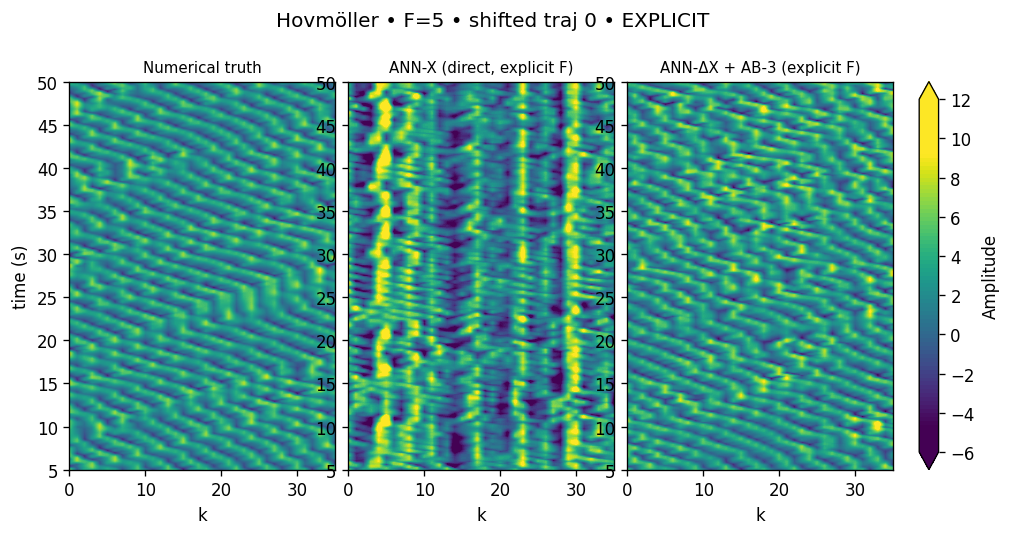

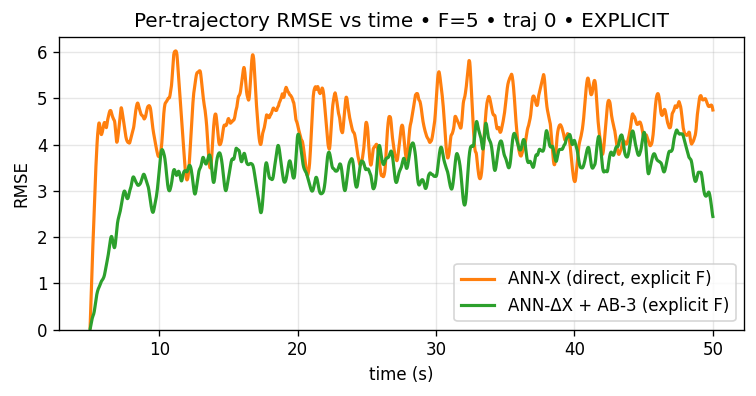

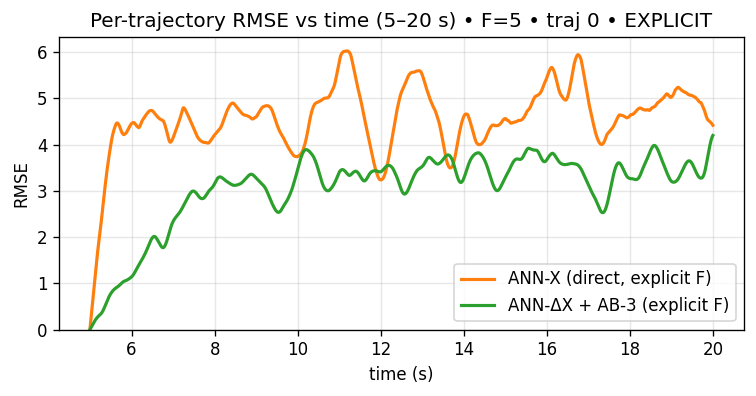

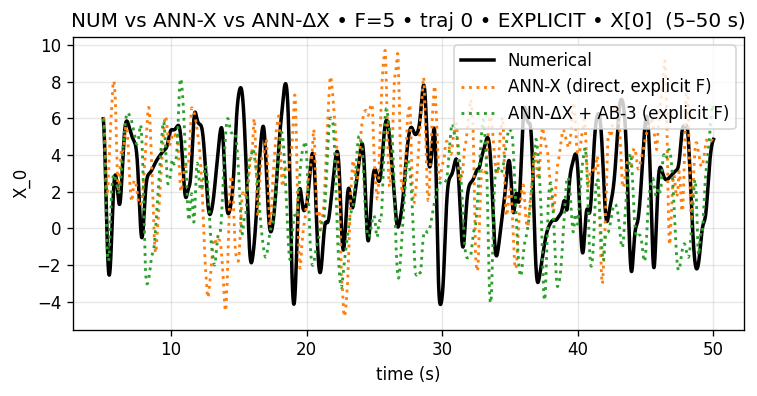

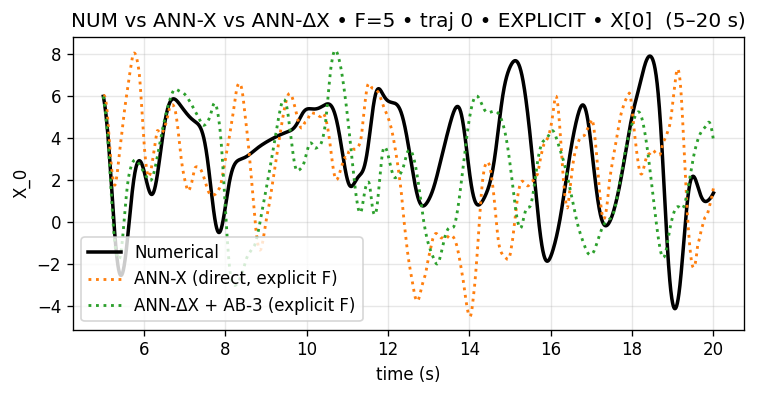

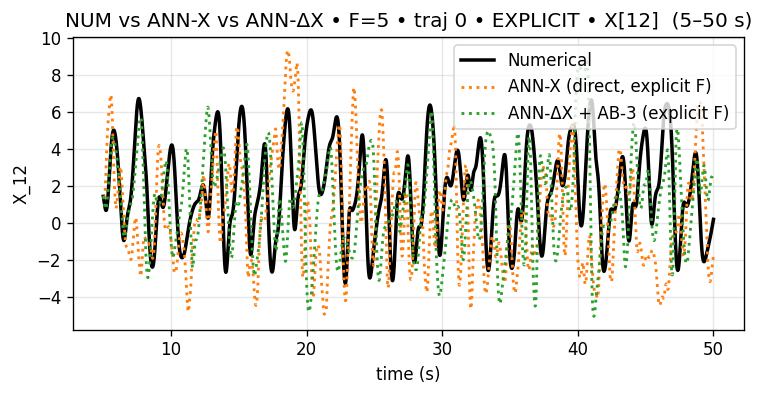

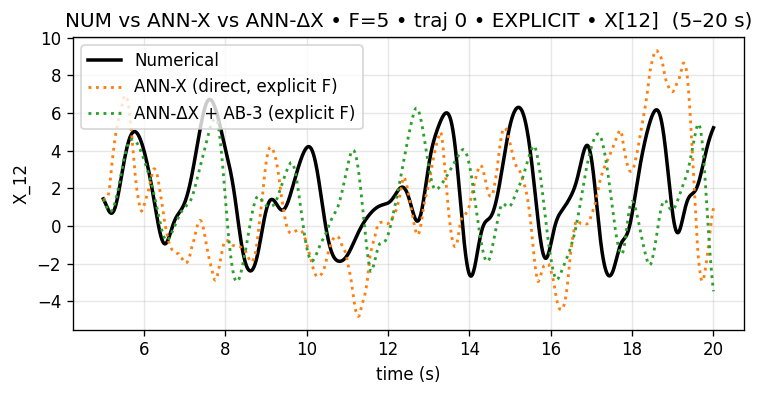


=== Forcing F = 10  |  shifted traj index 1 (EXPLICIT) ===


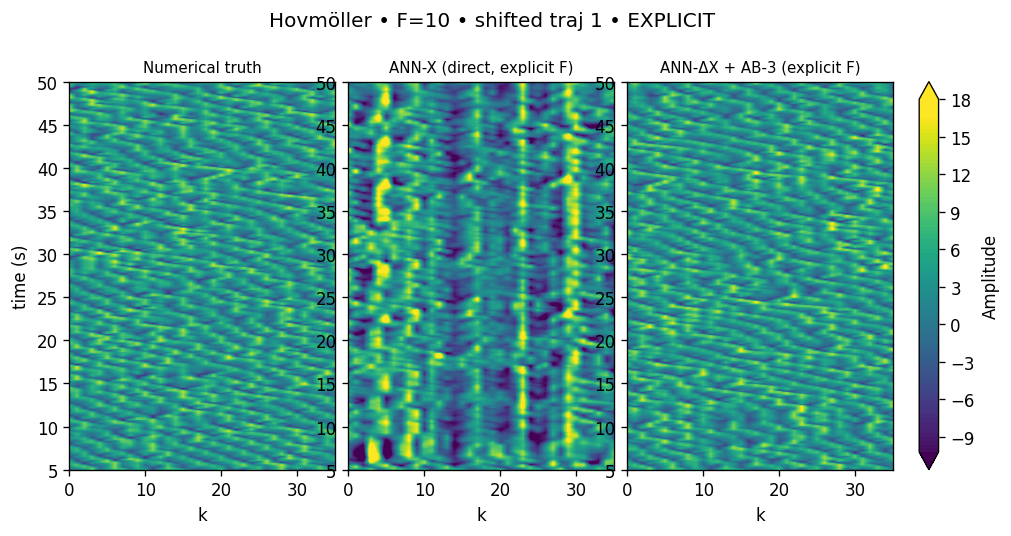

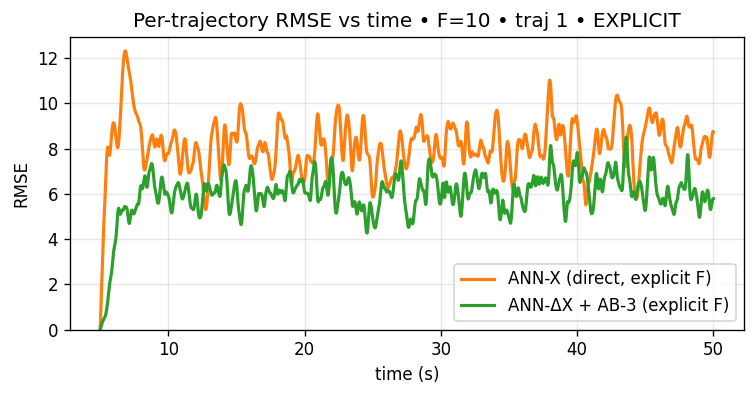

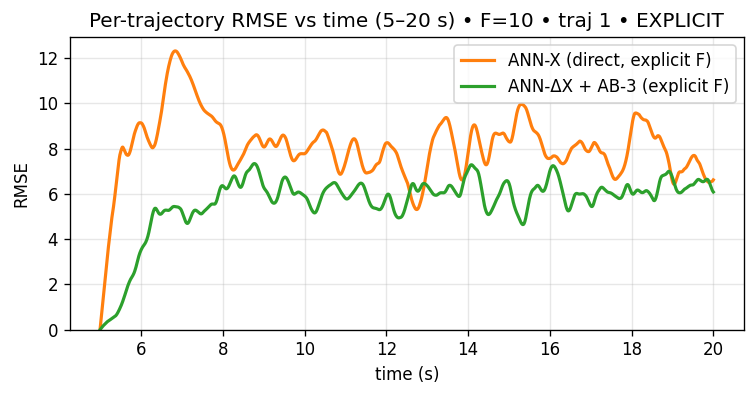

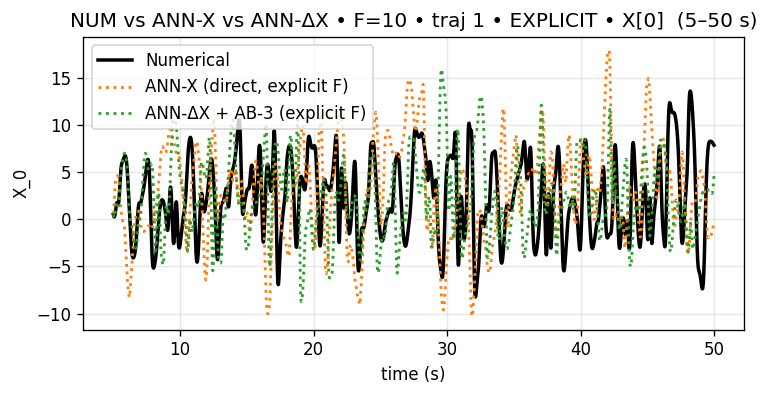

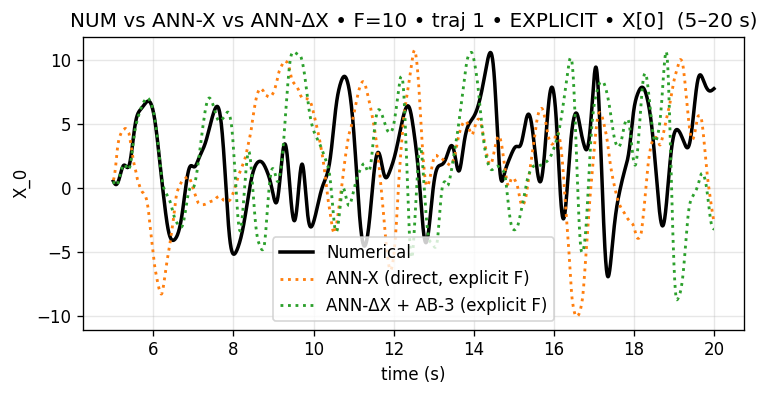

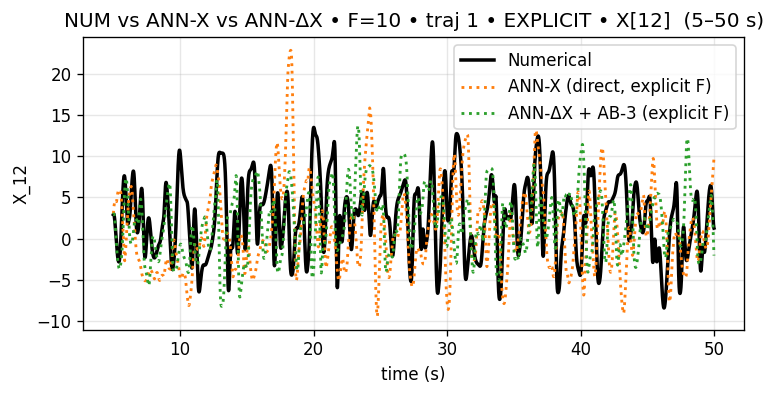

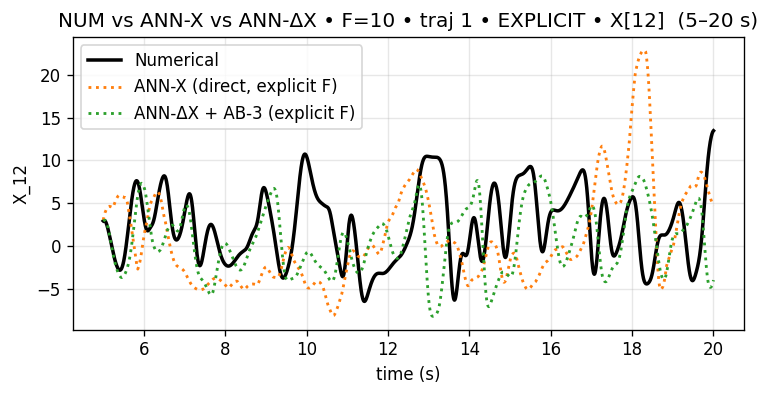


=== Forcing F = 15  |  shifted traj index 2 (EXPLICIT) ===


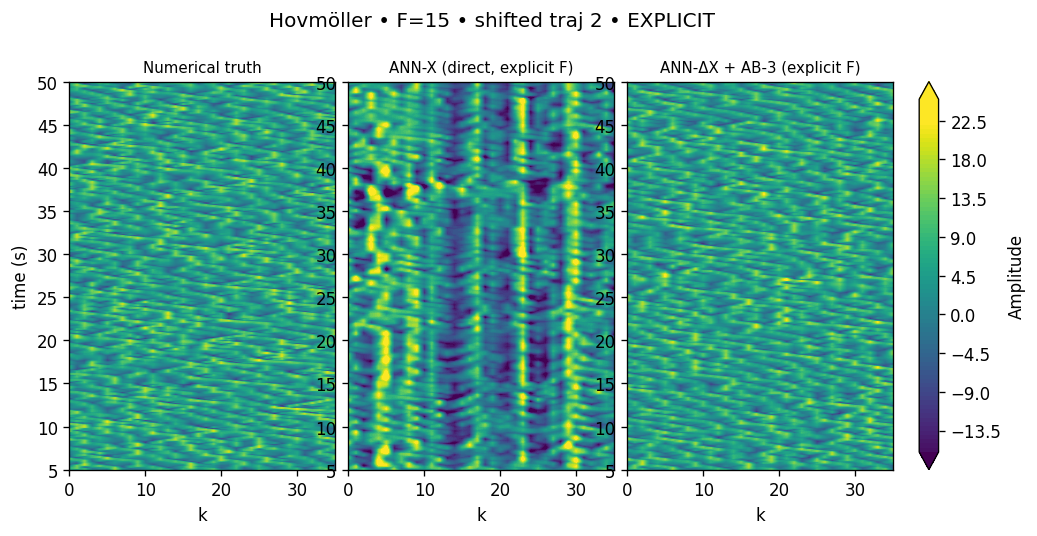

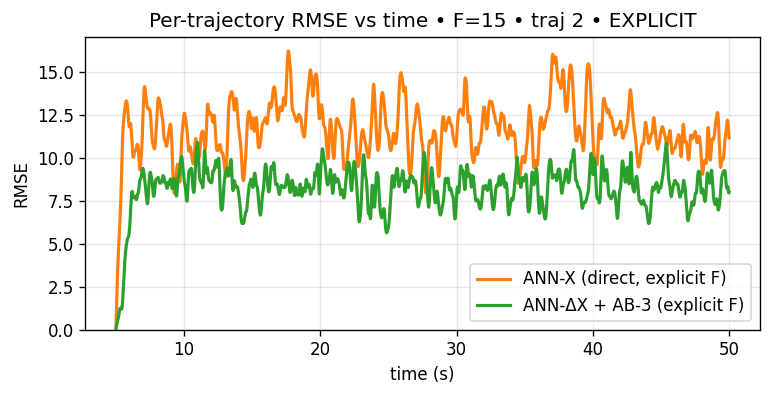

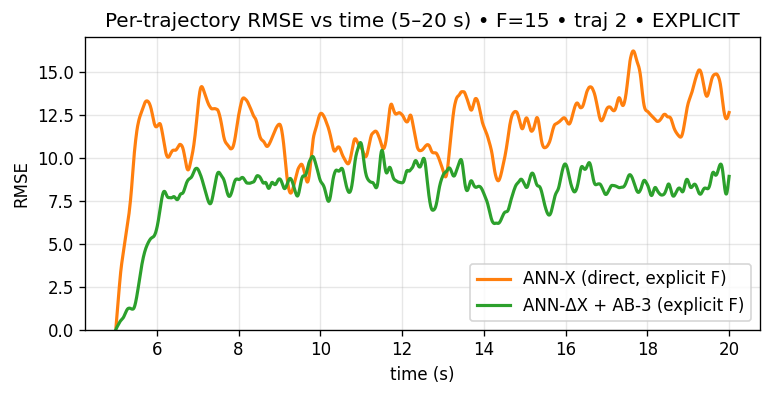

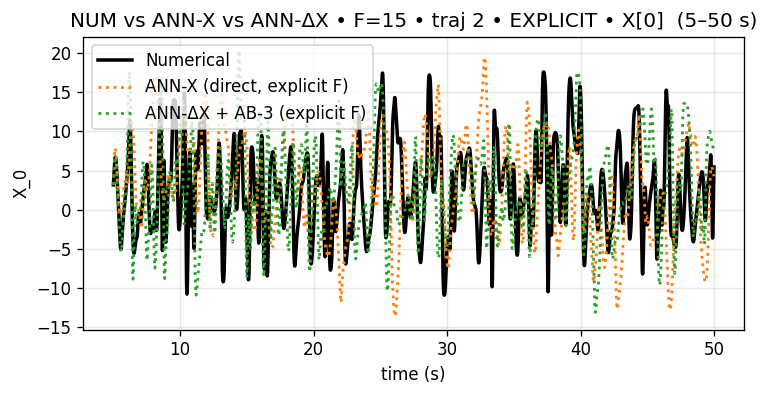

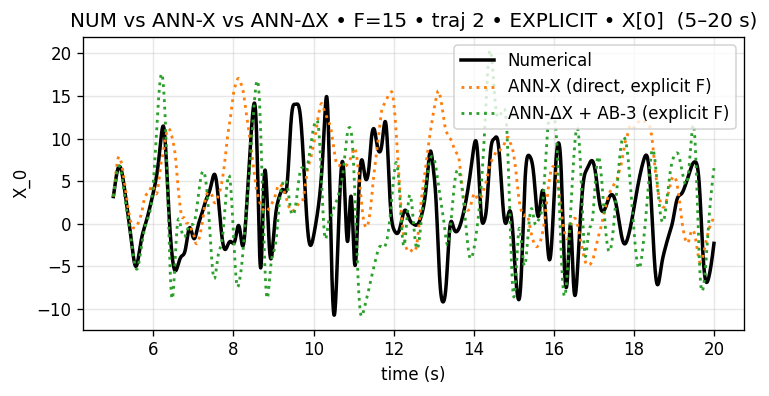

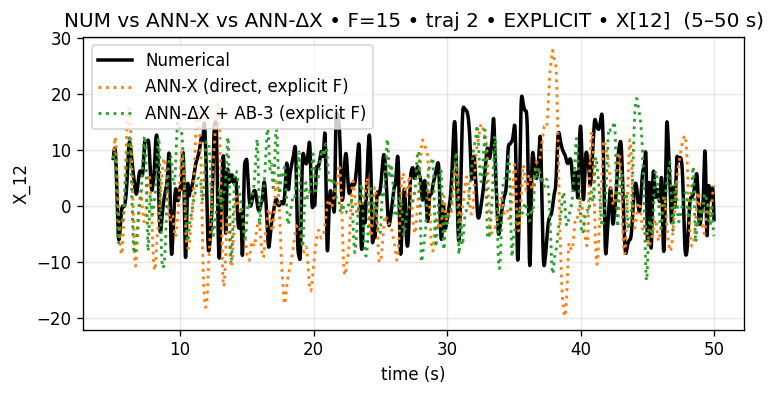

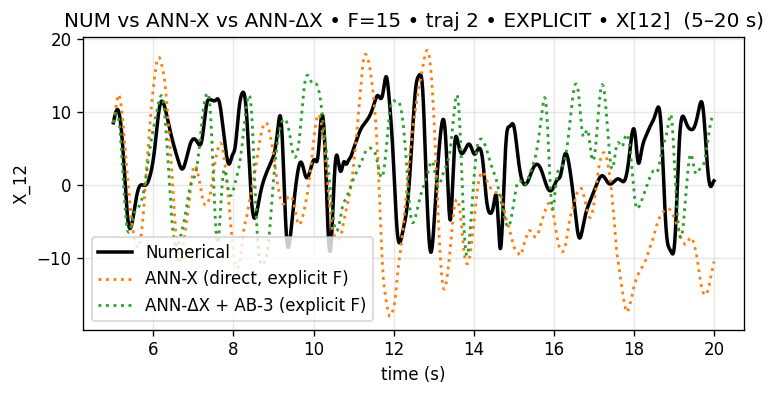


Done (explicit models).

[Supplementary • EXPLICIT] F = 5  |  shifted traj idx 0


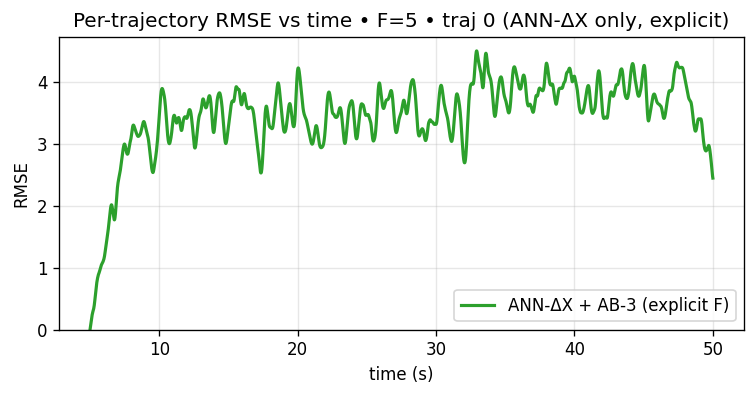

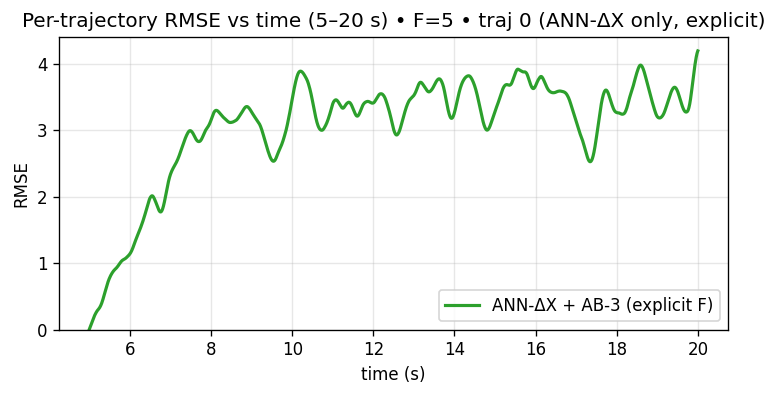

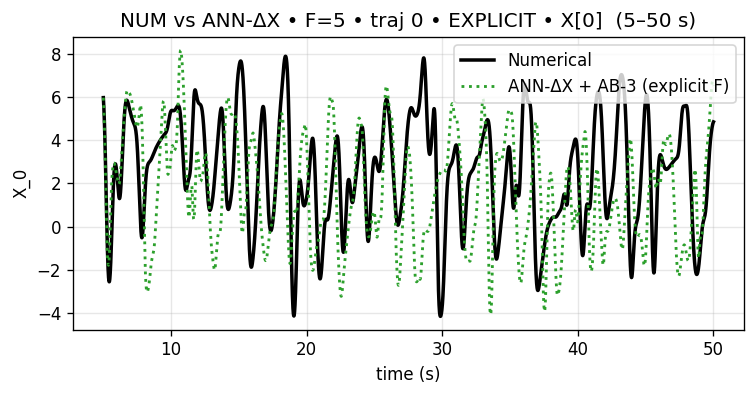

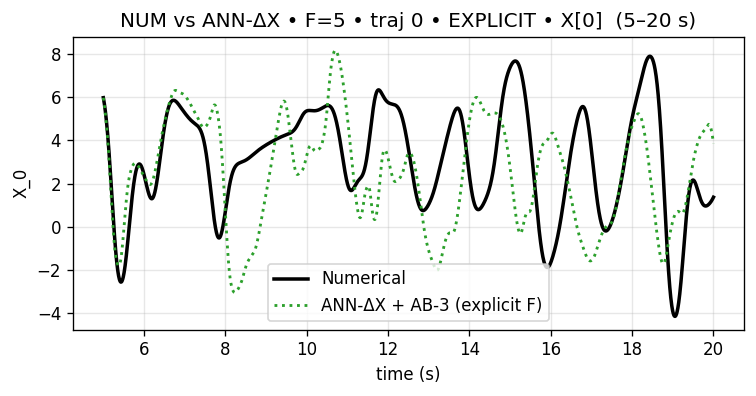

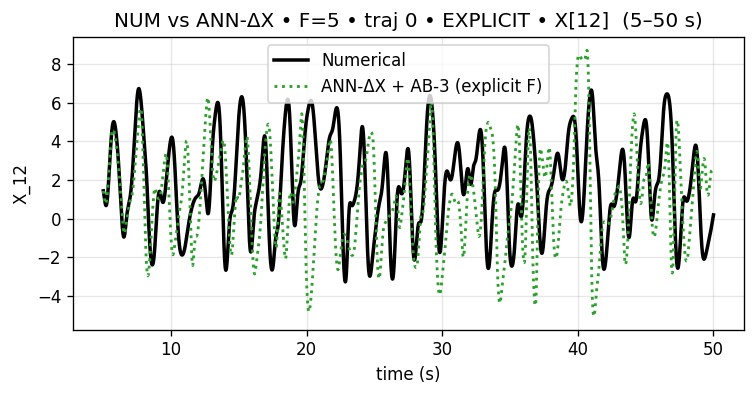

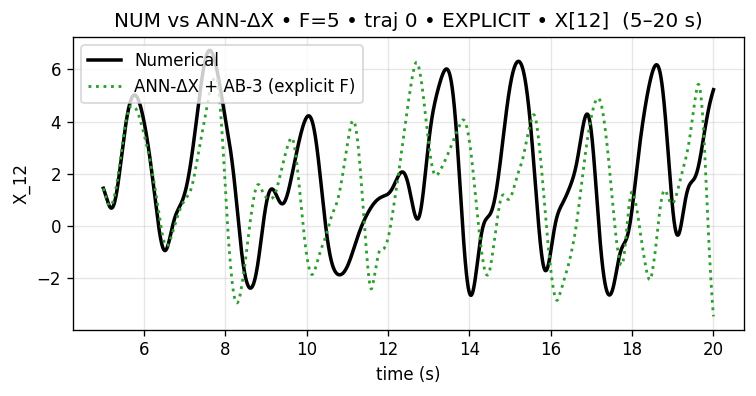


[Supplementary • EXPLICIT] F = 10  |  shifted traj idx 1


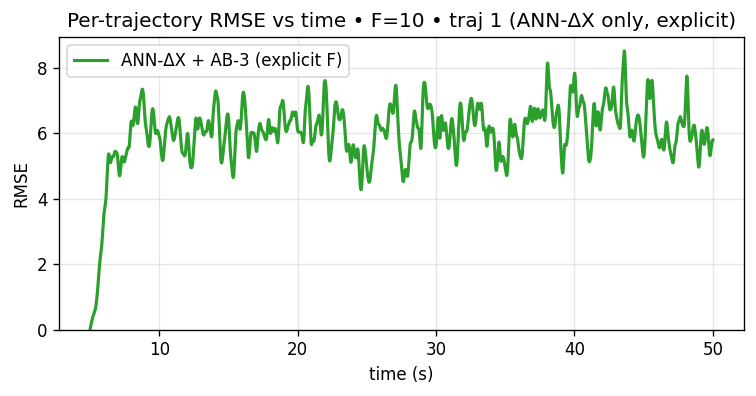

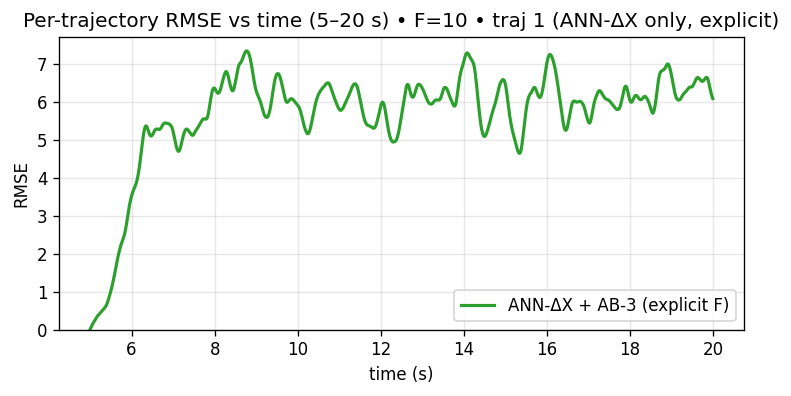

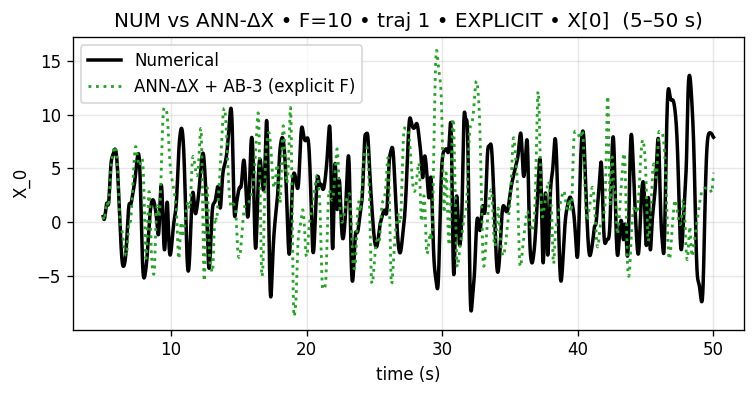

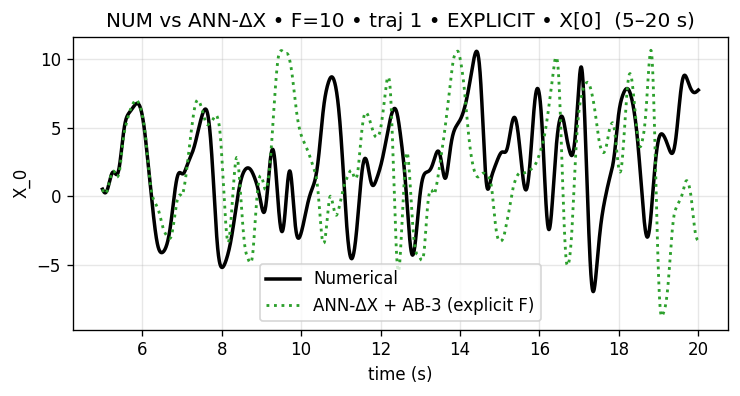

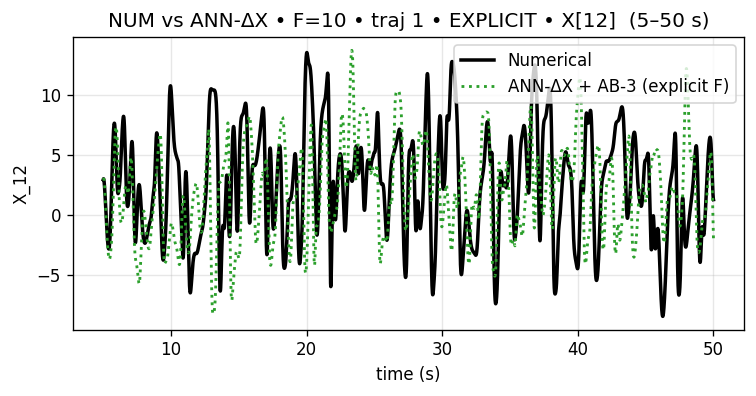

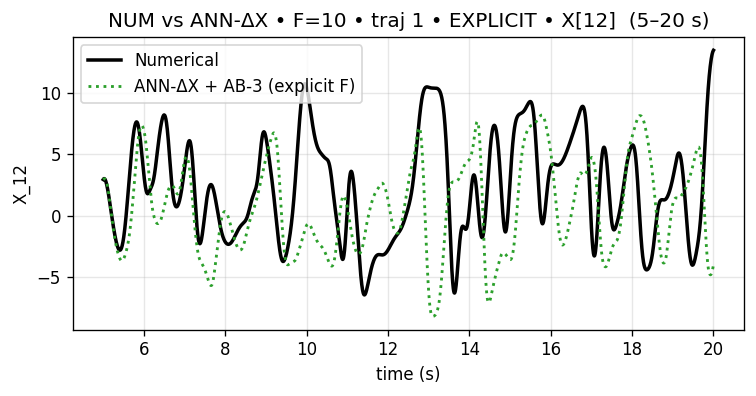


[Supplementary • EXPLICIT] F = 15  |  shifted traj idx 2


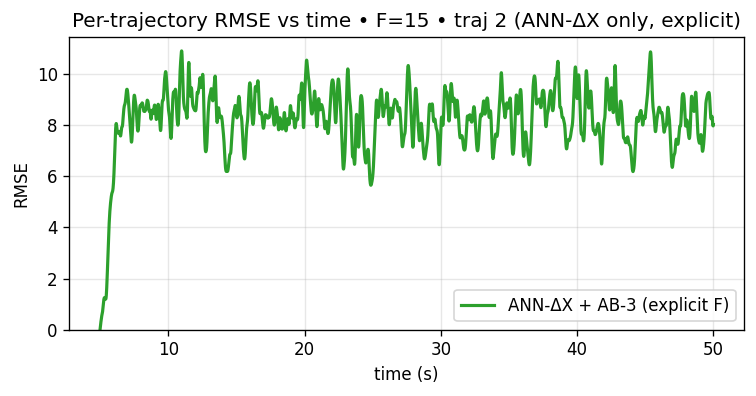

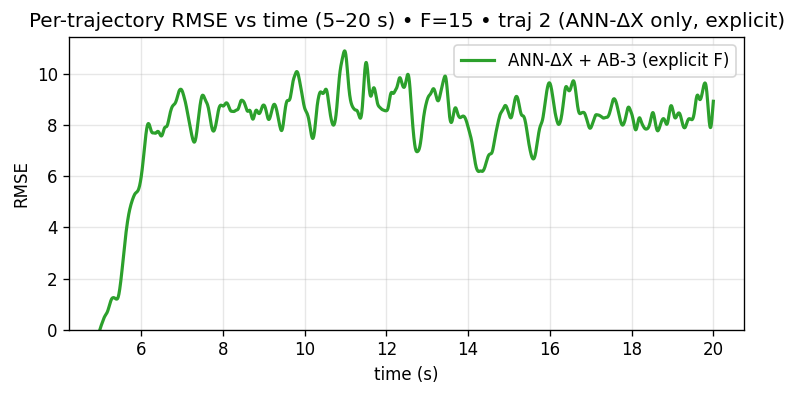

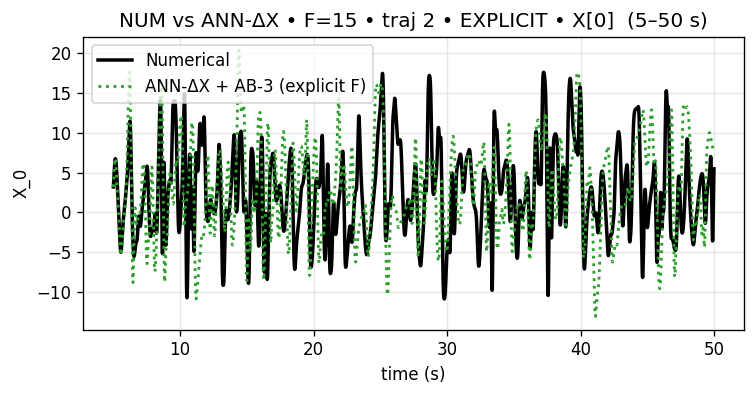

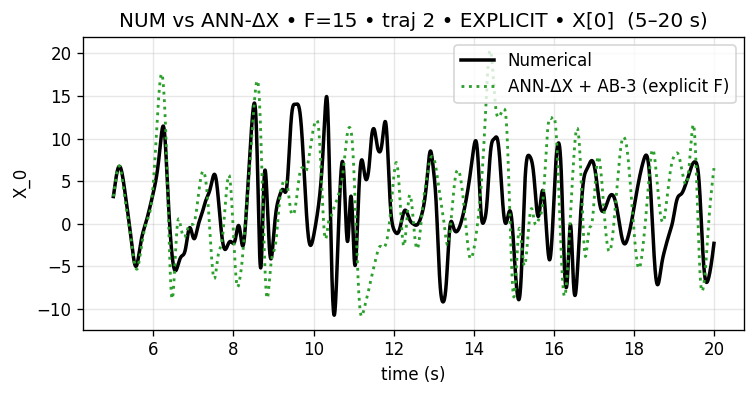

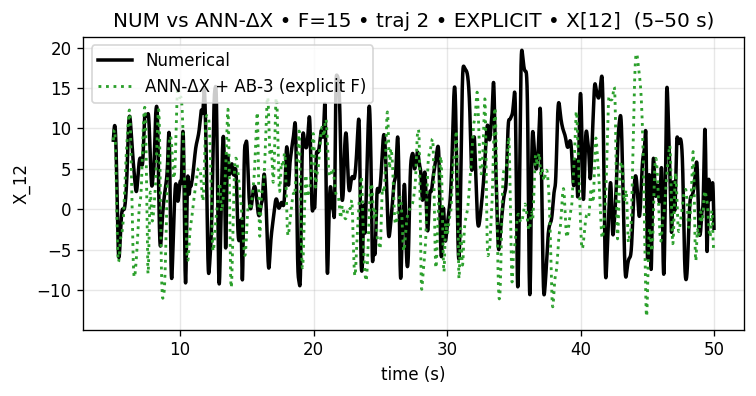

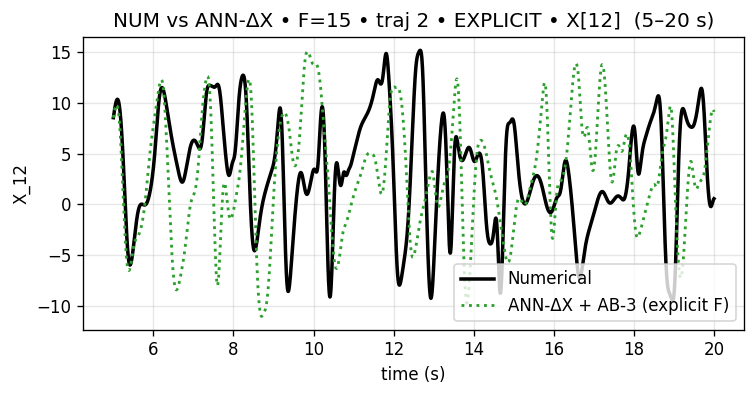


Supplementary panels (explicit) done.


In [2]:
#!/usr/bin/env python3
# =============================================================================
#  Quantitative panels (MULTIPLE EXPLICIT) — NUM vs ANN-X vs ANN-ΔX(+AB3)
#  ---------------------------------------------------------------------------
#  For each F ∈ {5,10,15}:
#    (A) Hovmöller:   NUM     | ANN-X         | ANN-ΔX(+AB3)
#    (B) RMSE(t):     ANN-X   | ANN-ΔX(+AB3)   (both vs NUM; SOLID lines)
#        ↳ also show a 5–20 s RMSE zoom panel
#    (C) X_k(t):      k ∈ {0,12}, window 5–50 s  +  zoom 5–20 s
#
#  Models: mixed-F (multiple **explicit**) ANNs:
#       CKPT_ANN_X  = standard_early_stopping_F5_10_15_EXPLICIT_annX.pt
#       CKPT_ANN_DX = standard_early_stopping_F5_10_15_EXPLICIT.pt
#
#  Normalisation & inputs (EXPLICIT):
#    • z-scores over X (36-dim) and over scalar F, computed on the *explicit*
#      training set file (fallback) or read from checkpoints if present.
#    • Inputs at rollout time are [ z(X(t)), z(F) ]  (37 dims), with z(F)
#      constant in time for a trajectory.
#    • ANN-X outputs z(X(t+Δt)) (direct next-state in z-space).
#    • ANN-ΔX outputs ΔX̂ in z-space; we roll out with Euler→AB2→AB3 in z-space.
#
#  Truth for evaluation: shifted, mixed-F set (only needs X and F).
# =============================================================================

import os, numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --------------------------- USER CONFIG ------------------------------------
FORCINGS     = [5.0, 10.0, 15.0]     # which F values to show
K_TO_PLOT    = (0, 12)               # components X[k] for line plots

# Files
TRAIN_FILE_EXPL = "force_5_10_15_explicitF.npz"      # for μ/σ over X and F
SHIFTED_FILE    = "shifted_force5_10_15_explicitF.npz"    # unseen truth (X,F)
CKPT_ANN_X      = "standard_early_stopping_F5_10_15_EXPLICIT_annX.pt"
CKPT_ANN_DX     = "standard_early_stopping_F5_10_15_EXPLICIT.pt"  # ΔX-ANN

# Time window
DT          = 0.005
T0, T1      = 5.0, 50.0              # main window for all panels
T_ZOOM_END  = 20.0                   # extra zoom for X_k(t) & RMSE (5–20 s)

# Device
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# --------------------------- TIME INDEXING ----------------------------------
steps_per_s = int(round(1/DT))
i0          = int(round(T0 * steps_per_s))
i_end       = int(round(T1 * steps_per_s))   # inclusive
t_axis      = np.arange(i0, i_end+1, dtype=np.float32) * DT

i_zoom_end  = int(round(T_ZOOM_END * steps_per_s))
if i_zoom_end <= i0:
    raise ValueError("T_ZOOM_END must be > T0.")
zoom_len    = i_zoom_end - i0 + 1            # number of samples in [T0, T_ZOOM_END]
t_axis_zoom = t_axis[:zoom_len]

# --------------------------- DATA & NORMALISATION ---------------------------
# Shifted truth (X, F)
dat_shift   = np.load(SHIFTED_FILE)
X_shift_all = dat_shift["X"].astype(np.float32)    # (traj, step, 36)
F_shift_all = dat_shift["F"].astype(np.float32)    # (traj,)
N_TRAJ, N_STEPS, N = X_shift_all.shape
assert i_end + 1 <= N_STEPS, "Requested [T0,T1] exceeds shifted data length"

# Fallback μ/σ from explicit training file (pooled across all F)
dat_train_expl = np.load(TRAIN_FILE_EXPL)
X_train_all    = dat_train_expl["X"].astype(np.float32)         # (99, step, 36)
F_train_all    = dat_train_expl["F"].astype(np.float32)         # (99,)
MU_X_FALL = X_train_all.reshape(-1, N).mean(0).astype(np.float32)         # (36,)
SD_X_FALL = (X_train_all.reshape(-1, N).std(0) + 1e-8).astype(np.float32) # (36,)
MU_F_FALL = float(F_train_all.mean().astype(np.float32))                   # scalar
SD_F_FALL = float((F_train_all.std() + 1e-8).astype(np.float32))           # scalar

# --------------------------- HELPERS ----------------------------------------
def find_state_dict(obj):
    """Locate a state_dict inside a checkpoint object (handles {'net':...} or raw SD)."""
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, (torch.Tensor, np.ndarray)) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = find_state_dict(v)
                if sd is not None:
                    return sd
    return None

def get_norms_from_ckpt_or_fallback(ckpt, mu_x_fall, sd_x_fall, mu_f_fall, sd_f_fall):
    """
    Robustly extract μ/σ for X and F from checkpoint if present, else fallback.
    Accepts keys: 'mean_X'/'std_X' or 'mean'/'std' (for X) and 'mean_F'/'std_F' (for F).
    """
    # X stats
    mu_x = np.asarray(ckpt.get("mean_X", ckpt.get("mean", mu_x_fall)), dtype=np.float32)
    sd_x = np.asarray(ckpt.get("std_X",  ckpt.get("std",  sd_x_fall)), dtype=np.float32)
    if mu_x.shape != (N,) or sd_x.shape != (N,):
        mu_x, sd_x = mu_x_fall, sd_x_fall
    # F stats
    mu_f = float(ckpt.get("mean_F", mu_f_fall))
    sd_f = float(ckpt.get("std_F",  sd_f_fall))
    if not np.isfinite(sd_f) or sd_f <= 0:
        mu_f, sd_f = mu_f_fall, sd_f_fall
    return mu_x.astype(np.float32), sd_x.astype(np.float32), np.float32(mu_f), np.float32(sd_f)

def ab3(dx1, dx_prev1, dx_prev2):
    """Euler → AB-2 → AB-3 combiner in z-space."""
    if dx_prev1 is None:
        return dx1
    if dx_prev2 is None:
        return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def make_mlp(sizes=(37,128,128,64,36), act="relu"):
    acts = dict(tanh=nn.Tanh, relu=nn.ReLU, gelu=nn.GELU)
    layers = []
    for i in range(len(sizes)-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if i < len(sizes) - 2:
            layers.append(acts[act]())
    return nn.Sequential(*layers)

def first_traj_index_for_F(F_value):
    """Return the first index in the shifted set with forcing == F_value."""
    idxs = np.where(np.isclose(F_shift_all, F_value))[0]
    if idxs.size == 0:
        raise RuntimeError(f"No shifted trajectory with F={F_value} in {SHIFTED_FILE}")
    return int(idxs[0])

# --------------------------- LOAD MODELS + μ/σ ------------------------------
# ANN-X (direct next-state in z-space) — 37→…→36
annx_ckpt = torch.load(CKPT_ANN_X, map_location="cpu")
ann_x     = make_mlp().to(DEVICE).eval()
ann_x.load_state_dict(annx_ckpt.get("net", find_state_dict(annx_ckpt) or annx_ckpt))
muX_annx, sdX_annx, muF_annx, sdF_annx = get_norms_from_ckpt_or_fallback(
    annx_ckpt, MU_X_FALL, SD_X_FALL, MU_F_FALL, SD_F_FALL
)

# ANN-ΔX (predict increments in z-space; rollout AB-3) — 37→…→36
annd_ckpt = torch.load(CKPT_ANN_DX, map_location="cpu")
ann_dx    = make_mlp().to(DEVICE).eval()
ann_dx.load_state_dict(annd_ckpt.get("net", find_state_dict(annd_ckpt) or annd_ckpt))
muX_annd, sdX_annd, muF_annd, sdF_annd = get_norms_from_ckpt_or_fallback(
    annd_ckpt, MU_X_FALL, SD_X_FALL, MU_F_FALL, SD_F_FALL
)

# --------------------------- ROLLOUTS (single trajectory) -------------------
@torch.no_grad()
def rollout_ann_x_explicit(traj_phys, F_scalar, mu_x, sd_x, mu_f, sd_f):
    """
    ANN-X (explicit): direct next-state in z-space. Input is [ z(X), z(F) ].
    Seed with z(X(t0-Δt)).  Returns (T, N) for t ∈ [T0, T1] in *physical* units.
    """
    # z-state at t0-Δt and constant z(F)
    prev_z = ((traj_phys[i0-1] - mu_x) / sd_x).astype(np.float32)  # (N,)
    zF     = np.float32((F_scalar - mu_f) / sd_f)                  # scalar
    prev   = torch.from_numpy(prev_z).to(DEVICE)
    zF_t   = torch.tensor([zF], dtype=torch.float32, device=DEVICE)  # (1,)

    mu_t   = torch.from_numpy(mu_x).to(DEVICE)
    sd_t   = torch.from_numpy(sd_x).to(DEVICE)

    preds = []
    for _ in range(i0, i_end+1):
        inp  = torch.cat([prev, zF_t]).unsqueeze(0)        # (1,37)
        nxt_z = ann_x(inp)                                 # (1,36)
        preds.append((nxt_z * sd_t + mu_t).squeeze(0).cpu().numpy())
        prev = nxt_z.squeeze(0)
    return np.stack(preds)                                  # (T,N)

@torch.no_grad()
def rollout_ann_dx_explicit(traj_phys, F_scalar, mu_x, sd_x, mu_f, sd_f):
    """
    ANN-ΔX (explicit): Euler→AB2→AB3 on ΔX̂ in z-space. Input is [ z(X), z(F) ].
    Seed with z(X(t0-Δt)).  Returns (T, N) for t ∈ [T0, T1] in *physical* units.
    """
    x_z  = ((traj_phys[i0-1] - mu_x) / sd_x).astype(np.float32)    # (N,)
    zF   = np.float32((F_scalar - mu_f) / sd_f)
    x    = torch.from_numpy(x_z).to(DEVICE)
    zF_t = torch.tensor([zF], dtype=torch.float32, device=DEVICE)

    mu_t = torch.from_numpy(mu_x).to(DEVICE)
    sd_t = torch.from_numpy(sd_x).to(DEVICE)

    preds = []
    dx_prev1 = dx_prev2 = None
    for _ in range(i0, i_end+1):
        inp  = torch.cat([x, zF_t]).unsqueeze(0)           # (1,37)
        dx1  = ann_dx(inp)                                  # (1,36)
        step = ab3(dx1, dx_prev1, dx_prev2)                 # (1,36)
        x    = x + step.squeeze(0)
        preds.append((x * sd_t + mu_t).cpu().numpy())
        dx_prev2, dx_prev1 = dx_prev1, dx1
    return np.stack(preds)                                   # (T,N)

# --------------------------- PLOTTING HELPERS -------------------------------
def hovmoller(t_axis, truth, pred1, pred2, lab1, lab2, suptitle):
    """3-panel Hovmöller: Numerical | pred1 | pred2"""
    vmin, vmax = float(truth.min()), float(truth.max())
    k_axis = np.arange(truth.shape[1])
    fig, axs = plt.subplots(1, 3, figsize=(9.4, 4.2), dpi=120, gridspec_kw={"wspace":0.05})
    for ax, mat, ttl in zip(axs, (truth, pred1, pred2), ("Numerical truth", lab1, lab2)):
        cf = ax.contourf(k_axis, t_axis, mat, 100, cmap="viridis",
                         vmin=vmin, vmax=vmax, extend="both")
        ax.set_xlabel("k"); ax.set_ylim(T0, T1)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(ttl, fontsize=9)
    axs[0].set_ylabel("time (s)")
    fig.colorbar(cf, ax=axs, fraction=0.028, pad=0.03, label="Amplitude")
    fig.suptitle(suptitle, y=1.02)
    plt.tight_layout(); plt.show()

def rmse_t(pred, truth):   # (T,N) → (T,)
    return np.sqrt(((pred - truth)**2).mean(axis=1))

def plot_rmse(t_axis, rmse1, rmse2, lab1, lab2, title):
    """Per-trajectory RMSE(t) vs NUM; **solid** lines."""
    plt.figure(figsize=(6.4, 3.4), dpi=120)
    plt.plot(t_axis, rmse1, lw=1.9, ls="-", color="tab:orange", label=lab1)
    plt.plot(t_axis, rmse2, lw=1.9, ls="-", color="tab:green",  label=lab2)
    plt.title(title); plt.xlabel("time (s)"); plt.ylabel("RMSE")
    plt.ylim(0); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

def plot_rmse_zoom(t_axis_zoom, rmse1_zoom, rmse2_zoom, lab1, lab2, title):
    """Zoomed per-trajectory RMSE(t) over 5–20 s; **solid** lines."""
    plt.figure(figsize=(6.4, 3.4), dpi=120)
    plt.plot(t_axis_zoom, rmse1_zoom, lw=1.9, ls="-", color="tab:orange", label=lab1)
    plt.plot(t_axis_zoom, rmse2_zoom, lw=1.9, ls="-", color="tab:green",  label=lab2)
    plt.title(title); plt.xlabel("time (s)"); plt.ylabel("RMSE")
    plt.ylim(0); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

def plot_traces_pair(t_axis, truth, pred1, pred2, k, lab1, lab2, title):
    """Single-k traces over the full window (5–50 s)."""
    plt.figure(figsize=(6.4, 3.4), dpi=120)
    plt.plot(t_axis, truth[:,k],   lw=2.1, ls="-", color="black",      label="Numerical")
    plt.plot(t_axis, pred1[:,k],   lw=1.7, ls=":", color="tab:orange", label=lab1)
    plt.plot(t_axis, pred2[:,k],   lw=1.7, ls=":", color="tab:green",  label=lab2)
    plt.title(f"{title} • X[{k}]  (5–50 s)")
    plt.xlabel("time (s)"); plt.ylabel(f"X_{k}")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_traces_pair_zoom(t_axis_zoom, truth, pred1, pred2, k, lab1, lab2, title):
    """Single-k traces over the zoom window (5–20 s)."""
    L = len(t_axis_zoom)
    plt.figure(figsize=(6.4, 3.4), dpi=120)
    plt.plot(t_axis_zoom, truth[:L,k], lw=2.1, ls="-", color="black",      label="Numerical")
    plt.plot(t_axis_zoom, pred1 [:L,k], lw=1.7, ls=":", color="tab:orange", label=lab1)
    plt.plot(t_axis_zoom, pred2 [:L,k], lw=1.7, ls=":", color="tab:green",  label=lab2)
    plt.title(f"{title} • X[{k}]  (5–20 s)")
    plt.xlabel("time (s)"); plt.ylabel(f"X_{k}")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# --------------------------- MAIN LOOP OVER F -------------------------------
for F_val in FORCINGS:
    traj_idx    = first_traj_index_for_F(F_val)
    truth_fixed = X_shift_all[traj_idx, i0:i_end+1]             # (T,N)

    # Emulator predictions (EXPLICIT inputs)
    ann_x_pred  = rollout_ann_x_explicit (X_shift_all[traj_idx], F_val, muX_annx, sdX_annx, muF_annx, sdF_annx)
    ann_dx_pred = rollout_ann_dx_explicit(X_shift_all[traj_idx], F_val, muX_annd, sdX_annd, muF_annd, sdF_annd)

    # Guard shapes for plotting
    assert ann_x_pred.shape  == truth_fixed.shape
    assert ann_dx_pred.shape == truth_fixed.shape

    print(f"\n=== Forcing F = {F_val:g}  |  shifted traj index {traj_idx} (EXPLICIT) ===")

    # (A) Hovmöller
    hovmoller(
        t_axis,
        truth_fixed, ann_x_pred, ann_dx_pred,
        "ANN-X (direct, explicit F)", "ANN-ΔX + AB-3 (explicit F)",
        f"Hovmöller • F={F_val:g} • shifted traj {traj_idx} • EXPLICIT"
    )

    # (B) RMSE(t) — full window (5–50 s), **solid** lines
    r1 = rmse_t(ann_x_pred,  truth_fixed)
    r2 = rmse_t(ann_dx_pred, truth_fixed)
    plot_rmse(
        t_axis, r1, r2,
        "ANN-X (direct, explicit F)",
        "ANN-ΔX + AB-3 (explicit F)",
        f"Per-trajectory RMSE vs time • F={F_val:g} • traj {traj_idx} • EXPLICIT"
    )

    # (B-zoom) RMSE(t) — 5–20 s, **solid** lines
    plot_rmse_zoom(
        t_axis_zoom, r1[:zoom_len], r2[:zoom_len],
        "ANN-X (direct, explicit F)",
        "ANN-ΔX + AB-3 (explicit F)",
        f"Per-trajectory RMSE vs time (5–20 s) • F={F_val:g} • traj {traj_idx} • EXPLICIT"
    )

    # (C) X_k(t) traces (full & zoom)
    for k in K_TO_PLOT:
        ttl = f"NUM vs ANN-X vs ANN-ΔX • F={F_val:g} • traj {traj_idx} • EXPLICIT"
        plot_traces_pair      (t_axis,      truth_fixed, ann_x_pred, ann_dx_pred, k,
                               "ANN-X (direct, explicit F)", "ANN-ΔX + AB-3 (explicit F)", ttl)
        plot_traces_pair_zoom (t_axis_zoom, truth_fixed, ann_x_pred, ann_dx_pred, k,
                               "ANN-X (direct, explicit F)", "ANN-ΔX + AB-3 (explicit F)", ttl)

print("\nDone (explicit models).")

# =============================================================================
#  SUPPLEMENTARY PANELS — Focus on ANN-ΔX(+AB3) only (no ANN-X), EXPLICIT
#  ---------------------------------------------------------------------------
#  For each F ∈ {5,10,15} using the *same selection rule* (first shifted traj):
#    • RMSE(t) vs NUM over 5–50 s (single curve: ANN-ΔX, solid green)
#    • RMSE(t) zoom 5–20 s (single curve: ANN-ΔX, solid green)
#    • X_k(t) traces for k ∈ {0,12} over 5–50 s and 5–20 s:
#         Numerical = solid black,  ANN-ΔX(+AB3) = dotted green
# =============================================================================

def plot_rmse_single(t_axis, rmse, label, title):
    plt.figure(figsize=(6.4, 3.4), dpi=120)
    plt.plot(t_axis, rmse, lw=1.9, ls="-", color="tab:green", label=label)
    plt.title(title); plt.xlabel("time (s)"); plt.ylabel("RMSE")
    plt.ylim(0); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

def plot_rmse_zoom_single(t_axis_zoom, rmse_zoom, label, title):
    plt.figure(figsize=(6.4, 3.4), dpi=120)
    plt.plot(t_axis_zoom, rmse_zoom, lw=1.9, ls="-", color="tab:green", label=label)
    plt.title(title); plt.xlabel("time (s)"); plt.ylabel("RMSE")
    plt.ylim(0); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

def plot_traces_single(t_axis, truth, pred, k, label, title):
    plt.figure(figsize=(6.4, 3.4), dpi=120)
    plt.plot(t_axis, truth[:,k], lw=2.1, ls="-", color="black",     label="Numerical")
    plt.plot(t_axis, pred [:,k], lw=1.7, ls=":", color="tab:green", label=label)
    plt.title(f"{title} • X[{k}]  (5–50 s)")
    plt.xlabel("time (s)"); plt.ylabel(f"X_{k}")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_traces_single_zoom(t_axis_zoom, truth, pred, k, label, title):
    L = len(t_axis_zoom)
    plt.figure(figsize=(6.4, 3.4), dpi=120)
    plt.plot(t_axis_zoom, truth[:L,k], lw=2.1, ls="-", color="black",     label="Numerical")
    plt.plot(t_axis_zoom, pred [:L,k], lw=1.7, ls=":", color="tab:green", label=label)
    plt.title(f"{title} • X[{k}]  (5–20 s)")
    plt.xlabel("time (s)"); plt.ylabel(f"X_{k}")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

for F_val in FORCINGS:
    traj_idx    = first_traj_index_for_F(F_val)
    truth_fixed = X_shift_all[traj_idx, i0:i_end+1]                         # (T,N)
    ann_dx_pred = rollout_ann_dx_explicit(X_shift_all[traj_idx], F_val,
                                          muX_annd, sdX_annd, muF_annd, sdF_annd)
    assert ann_dx_pred.shape == truth_fixed.shape

    print(f"\n[Supplementary • EXPLICIT] F = {F_val:g}  |  shifted traj idx {traj_idx}")

    r_dx = rmse_t(ann_dx_pred, truth_fixed)
    plot_rmse_single(
        t_axis, r_dx, "ANN-ΔX + AB-3 (explicit F)",
        f"Per-trajectory RMSE vs time • F={F_val:g} • traj {traj_idx} (ANN-ΔX only, explicit)"
    )
    plot_rmse_zoom_single(
        t_axis_zoom, r_dx[:zoom_len], "ANN-ΔX + AB-3 (explicit F)",
        f"Per-trajectory RMSE vs time (5–20 s) • F={F_val:g} • traj {traj_idx} (ANN-ΔX only, explicit)"
    )

    for k in K_TO_PLOT:
        ttl = f"NUM vs ANN-ΔX • F={F_val:g} • traj {traj_idx} • EXPLICIT"
        plot_traces_single      (t_axis,      truth_fixed, ann_dx_pred, k, "ANN-ΔX + AB-3 (explicit F)", ttl)
        plot_traces_single_zoom (t_axis_zoom, truth_fixed, ann_dx_pred, k, "ANN-ΔX + AB-3 (explicit F)", ttl)

print("\nSupplementary panels (explicit) done.")
